In [1]:
# Load all necessary packages
import sys
sys.path.append("../")

import numpy as np
from tqdm import tqdm

from aif360.datasets import CompasDataset, BankDataset, AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
import load_preproc_data_compas, load_preproc_data_german, load_preproc_data_adult

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset

import pandas as pd

from aif360.algorithms.postprocessing.lds_fairness import SubgroupFairOptimiser, InstantaneousFairOptimiser


import matplotlib.pyplot as plt
import matplotlib.text as mtext
        
import time

from tabulate import tabulate

C:\Users\01joh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
def load_compas_dataset(s,u,u_cat,x,y):
    def custom_preprocessing(df):
        mask = (df.days_b_screening_arrest <= 30) & \
               (df.days_b_screening_arrest >= -30) & \
               (df.is_recid != -1) & \
               (df.c_charge_degree != 'O') & \
               (df.score_text != 'N/A')
        df = df.loc[mask].copy()
        #print the length of the dataframe
        # Convert 'c_charge_degree' to numeric values
        charge_degree_map = {'M': 0, 'F': 1}  # Map 'M' to 0 and 'F' to 1
        df['c_charge_degree'] = df['c_charge_degree'].map(charge_degree_map)

        # Map 'Caucasian' to 1 and all other values to 0
        df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

        df['sex'] = df['sex'].apply(lambda x:1 if x == "Female" else 0)

        # Summing the relevant counts into a new column
        df['priors_total_count'] = (df['juv_fel_count'] + df['juv_misd_count'] + df['priors_count']) / 3

        df['age_under_25'] = df['age'].apply(lambda x:1 if x < 25 else 0)

        return df

    compas = CompasDataset(
        label_name=y,
        favorable_classes=[1],
        protected_attribute_names=[s],
        privileged_classes=[[1]],
        instance_weights_name=None,
        categorical_features=u_cat,
        features_to_keep=[s]+u+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,

        metadata={}
    )

    return compas

In [3]:
class LDS_Fairness_Evaluator:
    def __init__ (self,S, Y_hat):
        self.S = S
        self.Y_hat = Y_hat

    def evaluate(self, dataset_orig, dataset_repaired):
        D_orig = dataset_orig.convert_to_dataframe()[0]
        D_repaired = dataset_repaired#.convert_to_dataframe()[0]
        
        D_privileged_orig, D_unprivileged_orig = self._split_data(D_orig)
        D_privileged_repaired, D_unprivileged_repaired = self._split_data(D_repaired)
        
        Y_hat_orig_privileged = D_privileged_orig[self.Y_hat]
        Y_hat_orig_unprivileged = D_unprivileged_orig[self.Y_hat]
        Y_hat_repaired_privileged = D_privileged_repaired[self.Y_hat]
        Y_hat_repaired_unprivileged = D_unprivileged_repaired[self.Y_hat]

        perf_privileged = self.calculate_performance_metrics(Y_hat_orig_privileged, Y_hat_repaired_privileged)
        perf_unprivileged = self.calculate_performance_metrics(Y_hat_orig_unprivileged, Y_hat_repaired_unprivileged)
        
        # IND = abs(perf_I0[0] - perf_I1[0])
        # SP = abs(perf_I0[1] - perf_I1[1] + abs(perf_I1[2] - perf_I0[2]))
        # SF = abs(perf_I0[3] - perf_I1[3] + abs(perf_I0[4] - perf_I1[4]))
        # INA = (perf_I0[5] + perf_I1[5]) / (len(I0_test) + len(I1_test))

        metrics = {
            "IND": abs(perf_unprivileged[0] - perf_privileged[0]), # Independent difference
            "SP": abs(perf_unprivileged[1] - perf_privileged[1] + abs(perf_privileged[2] - perf_unprivileged[2])), # Separation
            "SF": abs(perf_unprivileged[3] - perf_privileged[3] + abs(perf_unprivileged[4] - perf_privileged[4])), # Sufficiency
            "INA": (perf_unprivileged[5] + perf_privileged[5]) / (len(D_orig)) # Inaccuracy
        }

        return metrics

    def calculate_performance_metrics(self, Y_hat_orig, Y_hat_repaired):
        TP = np.sum((Y_hat_orig == 1) & (Y_hat_repaired == 1))
        TN = np.sum((Y_hat_orig == 0) & (Y_hat_repaired == 0))
        FP = np.sum((Y_hat_orig == 0) & (Y_hat_repaired == 1))
        FN = np.sum((Y_hat_orig == 1) & (Y_hat_repaired == 0))
        NR = (TN+FN)/(len(Y_hat_orig))
        FPR = FP/(FP+TN+1e-10)
        FNR = FN/(FN+TP+1e-10)
        PPV = TP/(TP+FP+1e-10)
        NPV = TN/(TN+FN+1e-10)
        inACC = FP+FN
        return [NR, FPR, FNR, PPV, NPV, inACC]

    def _split_data(self, dataset):
        # Split the dataset into privileged and unprivileged groups based on the S attribute
        D_privileged = dataset[dataset[self.S] == 1]
        D_unprivileged = dataset[dataset[self.S] == 0]
        return D_privileged, D_unprivileged

In [4]:
S = 'race'
U = ['sex', 'age']
U_categorical = ['age_cat','c_charge_degree']
X = ['age_under_25','priors_total_count','decile_score']
Y_hat = 'is_recid'

In [5]:
metric_results = {'subgroup': [], 'instantaneous': []}
runtime_results = {'subgroup': [], 'instantaneous': []}
trials = 5
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

total_iterations = trials * len(splits)

with tqdm(total=total_iterations, desc="Progress") as pbar:
    for i in range(trials):
        for j, split in enumerate(splits):
            compas = load_compas_dataset(S, U, U_categorical, X, Y_hat)
            data_train, data_test = compas.split([0.2], shuffle=True)

            t1_sub = time.time()
            subgroup_fair_optimiser = SubgroupFairOptimiser(S, X, Y_hat)
            t2_sub = time.time()
            subgroup_fair_optimiser = subgroup_fair_optimiser.fit(data_train.copy())
            t3_sub = time.time()
            subgroup_repaired = subgroup_fair_optimiser.transform(data_test.copy())
            t4_sub = time.time()

            t1_inst = time.time()
            instantaneous_fair_optimiser = InstantaneousFairOptimiser(S, X, Y_hat)
            t2_inst = time.time()
            instantaneous_fair_optimiser = instantaneous_fair_optimiser.fit(data_train.copy())
            t3_inst = time.time()
            instantaneous_repaired = instantaneous_fair_optimiser.transform(data_test.copy())
            t4_inst = time.time()

            evaluator = LDS_Fairness_Evaluator(S, Y_hat)
            subgroup_repaired_metrics = evaluator.evaluate(data_test.copy(), subgroup_repaired.copy())
            instantaneous_repaired_metrics = evaluator.evaluate(data_test.copy(), instantaneous_repaired.copy())

            metric_results['subgroup'].append(subgroup_repaired_metrics)
            metric_results['instantaneous'].append(instantaneous_repaired_metrics)

            runtime_results['subgroup'].append({'fit': t3_sub - t2_sub, 'transform': t4_sub - t3_sub})
            runtime_results['instantaneous'].append({'fit': t3_inst - t2_inst, 'transform': t4_inst - t3_inst})

            pbar.update(1)
results = [metric_results, runtime_results]


Progress: 100%|██████████| 45/45 [15:04<00:00, 20.11s/it]


In [6]:
#save the results as a pickle file
import pickle
# with open('results.pkl', 'wb') as f:
    # pickle.dump(results, f)
#load the results from the pickle file
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

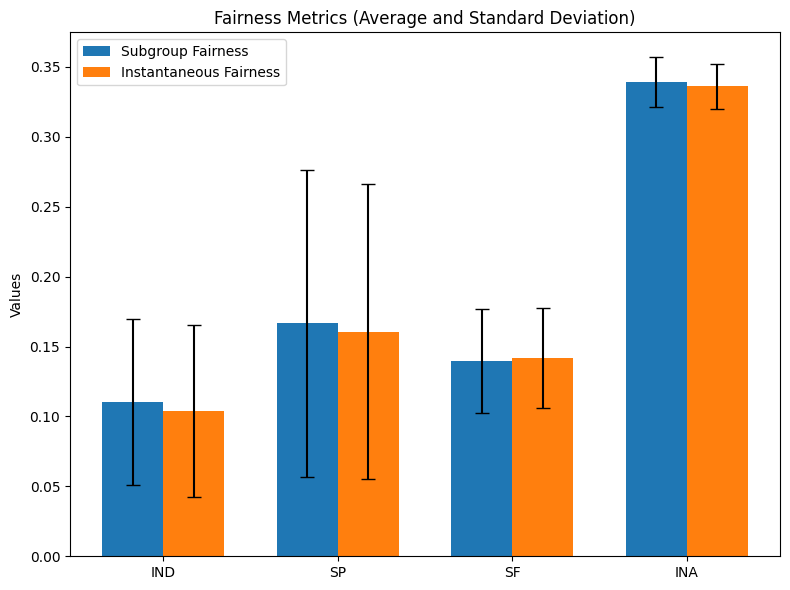

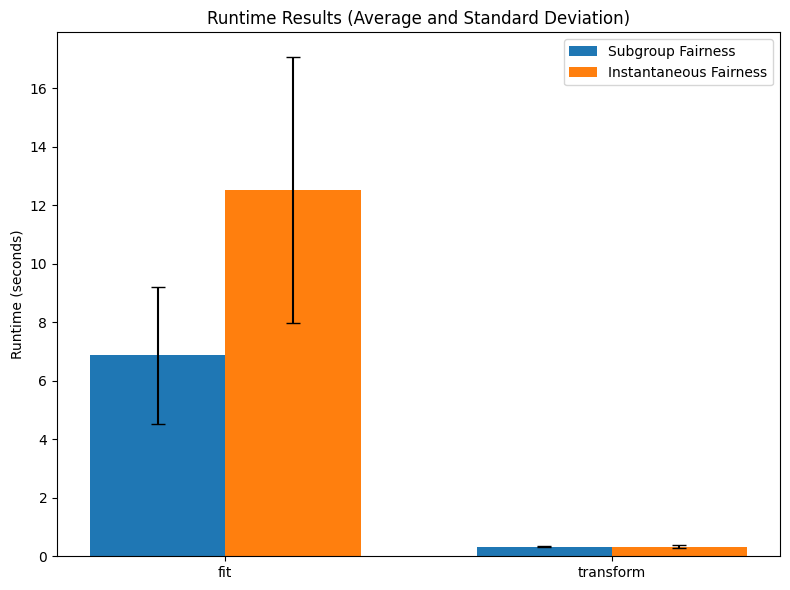

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metric_results and runtime_results are dictionaries containing lists of dictionaries

# Extract metric names
metrics = list(metric_results['subgroup'][0].keys())

# Calculate average and standard deviation for metric results
subgroup_metric_avg = {metric: np.mean([trial[metric] for trial in metric_results['subgroup']]) for metric in metrics}
subgroup_metric_std = {metric: np.std([trial[metric] for trial in metric_results['subgroup']]) for metric in metrics}
instantaneous_metric_avg = {metric: np.mean([trial[metric] for trial in metric_results['instantaneous']]) for metric in metrics}
instantaneous_metric_std = {metric: np.std([trial[metric] for trial in metric_results['instantaneous']]) for metric in metrics}

# Calculate average and standard deviation for runtime results
runtime_phases = list(runtime_results['subgroup'][0].keys())
subgroup_runtime_avg = {phase: np.mean([trial[phase] for trial in runtime_results['subgroup']]) for phase in runtime_phases}
subgroup_runtime_std = {phase: np.std([trial[phase] for trial in runtime_results['subgroup']]) for phase in runtime_phases}
instantaneous_runtime_avg = {phase: np.mean([trial[phase] for trial in runtime_results['instantaneous']]) for phase in runtime_phases}
instantaneous_runtime_std = {phase: np.std([trial[phase] for trial in runtime_results['instantaneous']]) for phase in runtime_phases}

# Plotting metric results
x = range(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar([i - width/2 for i in x], list(subgroup_metric_avg.values()), width, yerr=list(subgroup_metric_std.values()), capsize=5, label='Subgroup Fairness')
ax.bar([i + width/2 for i in x], list(instantaneous_metric_avg.values()), width, yerr=list(instantaneous_metric_std.values()), capsize=5, label='Instantaneous Fairness')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Values')
ax.set_title('Fairness Metrics (Average and Standard Deviation)')
ax.legend()
plt.tight_layout()
plt.show()

# Plotting runtime results
x = range(len(runtime_phases))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar([i - width/2 for i in x], list(subgroup_runtime_avg.values()), width, yerr=list(subgroup_runtime_std.values()), capsize=5, label='Subgroup Fairness')
ax.bar([i + width/2 for i in x], list(instantaneous_runtime_avg.values()), width, yerr=list(instantaneous_runtime_std.values()), capsize=5, label='Instantaneous Fairness')
ax.set_xticks(x)
ax.set_xticklabels(runtime_phases)
ax.set_ylabel('Runtime (seconds)')
ax.set_title('Runtime Results (Average and Standard Deviation)')
ax.legend()
plt.tight_layout()
plt.show()

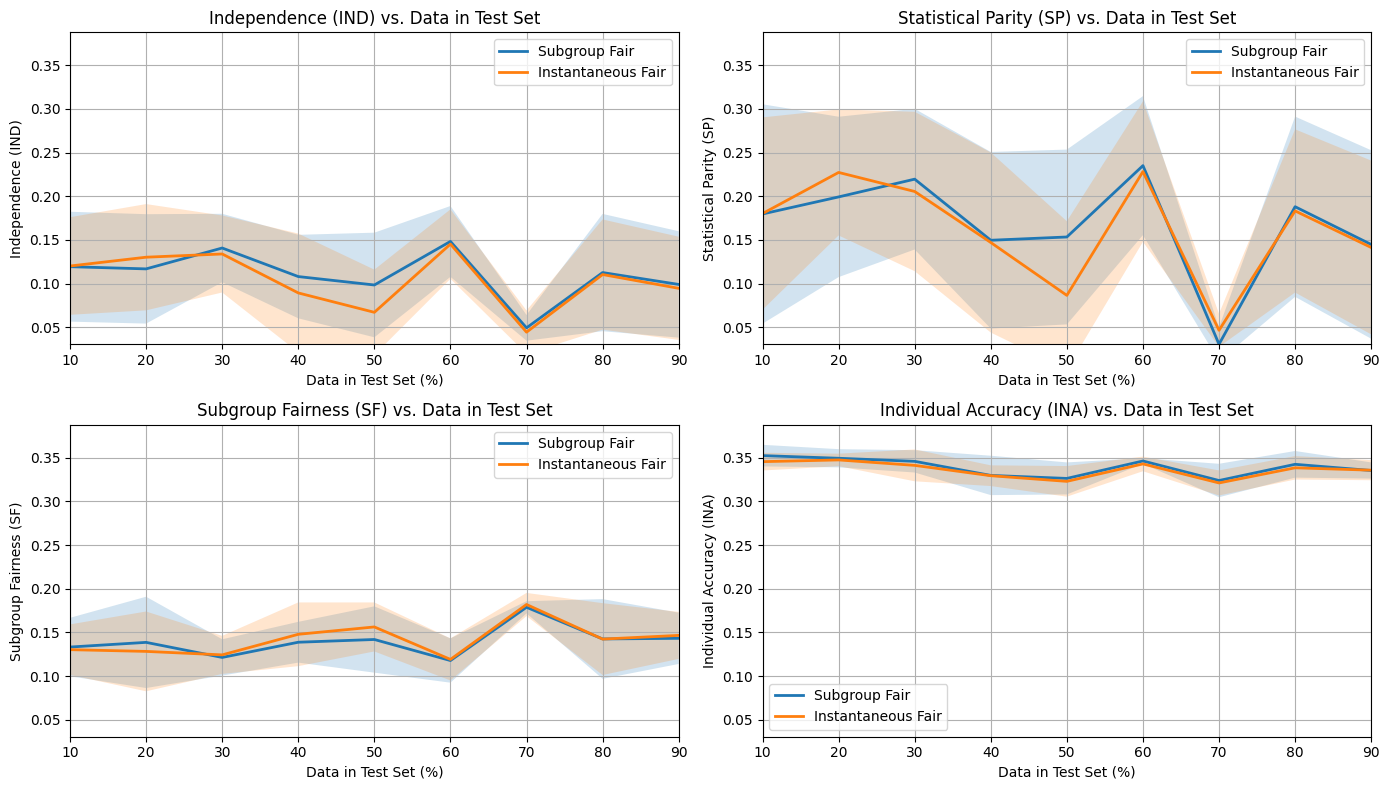

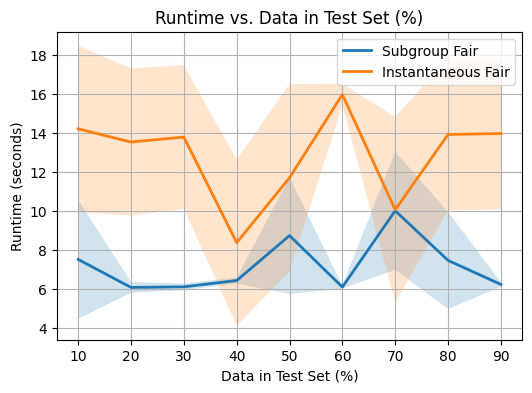

In [13]:
import numpy as np
import matplotlib.pyplot as plt

subgroup_runtimes = [np.mean([r['fit'] + r['transform'] for r in runtime_results['subgroup'][k::len(splits)]]) for k in range(len(splits))]
instantaneous_runtimes = [np.mean([r['fit'] + r['transform'] for r in runtime_results['instantaneous'][k::len(splits)]]) for k in range(len(splits))]
subgroup_runtimes_std = [np.std([r['fit'] + r['transform'] for r in runtime_results['subgroup'][k::len(splits)]]) for k in range(len(splits))]
instantaneous_runtimes_std = [np.std([r['fit'] + r['transform'] for r in runtime_results['instantaneous'][k::len(splits)]]) for k in range(len(splits))]
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Dictionary to map metric keys to subplot positions and titles
metric_info = {
    'IND': (0, 0, 'Independence (IND)'),
    'SP': (0, 1, 'Statistical Parity (SP)'),
    'SF': (1, 0, 'Subgroup Fairness (SF)'),
    'INA': (1, 1, 'Individual Accuracy (INA)')
}

# Set the same x-axis and y-axis limits for all subplots
x_min, x_max = np.min(np.array(splits) * 100), np.max(np.array(splits) * 100)
y_min, y_max = float('inf'), float('-inf')

# Iterate over each metric and create a subplot
for metric_key, (i, j, title) in metric_info.items():
    # Extract metric values for each split
    subgroup_metrics = [np.mean([m[metric_key] for m in metric_results['subgroup'][k::len(splits)]]) for k in range(len(splits))]
    instantaneous_metrics = [np.mean([m[metric_key] for m in metric_results['instantaneous'][k::len(splits)]]) for k in range(len(splits))]
    
    # Calculate standard deviation of metric values for each split
    subgroup_metrics_std = [np.std([m[metric_key] for m in metric_results['subgroup'][k::len(splits)]]) for k in range(len(splits))]
    instantaneous_metrics_std = [np.std([m[metric_key] for m in metric_results['instantaneous'][k::len(splits)]]) for k in range(len(splits))]
    
    # Update y-axis limits
    y_min = min(y_min, np.min(subgroup_metrics), np.min(instantaneous_metrics))
    y_max = max(y_max, np.max(subgroup_metrics), np.max(instantaneous_metrics))
    
    # Plot the metric subplot
    axs[i, j].plot(np.array(splits) * 100, subgroup_metrics, label='Subgroup Fair', linewidth=2)
    axs[i, j].fill_between(np.array(splits) * 100, [m - s for m, s in zip(subgroup_metrics, subgroup_metrics_std)], [m + s for m, s in zip(subgroup_metrics, subgroup_metrics_std)], alpha=0.2)
    axs[i, j].plot(np.array(splits) * 100, instantaneous_metrics, label='Instantaneous Fair', linewidth=2)
    axs[i, j].fill_between(np.array(splits) * 100, [m - s for m, s in zip(instantaneous_metrics, instantaneous_metrics_std)], [m + s for m, s in zip(instantaneous_metrics, instantaneous_metrics_std)], alpha=0.2)
    axs[i, j].set_xlabel('Data in Test Set (%)')
    axs[i, j].set_ylabel(title)
    axs[i, j].set_title(title + ' vs. Data in Test Set')
    axs[i, j].legend()
    axs[i, j].grid(True)

# Set the same x-axis and y-axis limits for all subplots
for i in range(2):
    for j in range(2):
        axs[i, j].set_xlim(x_min, x_max)
        axs[i, j].set_ylim(y_min, y_max*1.1)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Create the runtime plot
plt.figure(figsize=(6, 4))
plt.plot(np.array(splits) * 100, subgroup_runtimes, label='Subgroup Fair', linewidth=2)
plt.fill_between(np.array(splits) * 100, [r - s for r, s in zip(subgroup_runtimes, subgroup_runtimes_std)], [r + s for r, s in zip(subgroup_runtimes, subgroup_runtimes_std)], alpha=0.2)
plt.plot(np.array(splits) * 100, instantaneous_runtimes, label='Instantaneous Fair', linewidth=2)
plt.fill_between(np.array(splits) * 100, [r - s for r, s in zip(instantaneous_runtimes, instantaneous_runtimes_std)], [r + s for r, s in zip(instantaneous_runtimes, instantaneous_runtimes_std)], alpha=0.2)
plt.xlabel('Data in Test Set (%)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Data in Test Set (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import inspect
import networkx as nx
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import scrolledtext

def get_class_structure(cls):
    structure = f"Class: {cls.__name__}\n"
    for name, obj in inspect.getmembers(cls):
        if inspect.isfunction(obj):
            args = inspect.signature(obj)
            structure += f"\n  Method: {name}{args}"
        elif not name.startswith("__"):
            structure += f"\n  Attribute: {name}"
    return structure
def create_flowchart(cls):
    G = nx.DiGraph()
    for name, obj in inspect.getmembers(cls):
        if inspect.isfunction(obj):
            G.add_node(name)

    for name, obj in inspect.getmembers(cls):
        if inspect.isfunction(obj):
            source_lines = inspect.getsourcelines(obj)[0]
            print(f"Analyzing function: {name}")
            for line in source_lines:
                line = line.strip()
                print(f"  Line: {line}")
                if 'self.' in line:
                    print("    Contains 'self.'")
                    parts = line.split('self.')[1].split('(')
                    method_name = parts[0].strip()
                    print(f"    Method name: {method_name}")
                    data_passed = []
                    if '(' in line and ')' in line:
                        data_passed = [d.strip() for d in parts[1].split(')')[0].split(',') if d.strip()]
                        print(f"    Data passed: {data_passed}")
                    if method_name in [n for n, o in inspect.getmembers(cls) if inspect.isfunction(o)]:
                        print(f"    {method_name} is a valid method")
                        if data_passed:
                            edge_label = ', '.join(data_passed)
                            G.add_edge(name, method_name, label=edge_label)
                            print(f"    Edge added: {name} -> {method_name} (Label: {edge_label})")
                        else:
                            G.add_edge(name, method_name)
                            print(f"    Edge added: {name} -> {method_name}")

    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=12, arrows=True)
    labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig('flowchart.png', format='png')
    plt.close()

def show_popup(cls):
    structure = get_class_structure(cls)
    create_flowchart(cls)
    
    window = tk.Tk()
    window.title(f"{cls.__name__} Structure and Flowchart")
    
    text_area = scrolledtext.ScrolledText(window, width=60, height=20)
    text_area.insert(tk.END, structure)
    text_area.configure(state='disabled')
    text_area.pack(pady=10)
    
    flowchart_image = tk.PhotoImage(file='flowchart.png')
    flowchart_label = tk.Label(window, image=flowchart_image)
    flowchart_label.pack()
    
    window.mainloop()

    

show_popup(SubgroupFairOptimiser)